<a href="https://colab.research.google.com/github/JasaZnidar/Predvidenje-zmagovalca-vaterpolo/blob/homogen-classification-GCN-Mk.-4/Diplomska_naloga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this model, real data is used to construct the model.

The data is stored in a Heterogeneus graph.
A node is a team and it's feature is the average team statistic.

An edge represents a match. For each match there are 2 edges. It represents the result, from the originating node teams point of view. Meaning that if the number is negative, they lost. The absolute value is the difference in gols. This value is also used as a weight for the edges during learning.

To predict the result, we use a GCN evalueate all teams, concatinate these evaluations in acordance with the edge we are trying to predict (originating node team is first) and then do a linear regression to get a single value, which is the result.

We also filter out matches that result in a tie.

# Setup

## Download whl-s and requirements

In [1]:
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/JasaZnidar/Predvidenje-zmagovalca-vaterpolo/refs/heads/main/requirements.txt", "requirements.txt")

('requirements.txt', <http.client.HTTPMessage at 0x793bd46ee050>)

## pip

In [2]:
!sudo apt-get install libcairo2-dev pkg-config python3-dev
!pip install --upgrade pip
!pip install --force-reinstall --no-cache-dir pycairo

!pip install -r requirements.txt

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libcairo2-dev is already the newest version (1.16.0-5ubuntu2).
pkg-config is already the newest version (0.29.2-1ubuntu3).
python3-dev is already the newest version (3.10.6-1~22.04.1).
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 47 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.5/661.5 kB 237.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycairo: filename=pycairo-1.27.0-cp310-cp310-linux_x86_64.whl size=128157 sha256=854aa14d66866fe4af4acaa61e3db1c35952f0330a1dd3d3cb05feeb15ef6f64
  Stored in directory: /tmp/pip-ephem-wheel-cache-98ue2jwk/whee

# Imports

In [3]:
import json
import networkx as nx
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.utils.convert import from_networkx
from torch_geometric import nn, sampler
from torch_geometric.data import HeteroData, Data
from torch_geometric import transforms as T
from torch_geometric import loader
from torcheval import metrics as M
from torcheval.metrics import R2Score, MeanSquaredError
import tqdm
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import requests
from zipfile import ZipFile
from math import log
from io import BytesIO
%matplotlib inline

# Data definition

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

win_value = 1.0
loss_value = -1.0
tie_value = (win_value + loss_value)/2

data_file = "test"
train_rate = 0.7
val_rate = 1.0 - train_rate

## Get JSON data from github

In [5]:
with requests.get(f"https://github.com/JasaZnidar/totalwaterpolo-web-scraper/raw/master/{data_file}.zip", ) as r:
  ZipFile(BytesIO(r.content), "r").extractall()

## Extract data to json object

In [6]:
with open(f"/content/{data_file}.json") as f:
    scraped_data = json.load(f)

## Supporting functions

### Event data to vector data

In [7]:
def eventToVector(event: dict) -> tuple[list[float], list[float]]:
  player1Statistic = [0.0]*11
  player2Statistic = [0.0]*11

  if "goal scored" in event['action']:
    # goals
    player1Statistic[0] += 1
    # shots
    player1Statistic[1] += 1
    # assists
    player2Statistic[2] += 1

  elif "exclusion" in event['action']:
    # exclusion
    player1Statistic[5] += 1

  elif "penalty foul" in event['action']:
    # penalty
    player1Statistic[6] += 1

  elif "shot missed" in event['action']:
    # shots
    player1Statistic[1] += 1

  elif "shot saved" in event['action']:
    # shots
    player1Statistic[1] += 1

  elif "shot blocked" in event['action']:
    # shots
    player1Statistic[1] += 1
    # blocks
    player2Statistic[3] += 1

  elif "suspention" in event['action']:
    # suspensions
    player1Statistic[7] += 1

  elif "brutality" in event['action']:
    # brutalities
    player1Statistic[8] += 1

  elif "sprint won" in event['action']:
    # sprint won
    player1Statistic[9] += 1
    # sprint
    player1Statistic[10] += 1
    # sprint
    player2Statistic[10] += 1

  return (player1Statistic, player2Statistic);

### Is second player ally

In [8]:
def isAlly(event: dict) -> bool:
  if 'goal scored' in event['action']:
    return True
  return False

### Update list

In [9]:
def Update(original: list, update: list) -> list:
  assert len(original) == len(update)

  return[original[x] + update[x] for x in range(len(original))]

## Sort matches by date and save those that have no date

In [10]:
sorted_match_ids = []
unknown_date_match_ids = []
breakpoint_match_id = ("", -1)
for match_id in scraped_data['matches']:
  if 'date' in scraped_data['matches'][match_id]:
    sorted_match_ids.append((match_id, scraped_data['matches'][match_id]['date']))
  else:
    unknown_date_match_ids.append(match_id)

# sort matches
sorted_match_ids = sorted(sorted_match_ids, key=lambda t: t[1])
sorted_match_ids = [m[0] for m in sorted_match_ids]

## Data generation

### Team data gathering

In [11]:
match_list = sorted_match_ids
results = {}
team_data = {}

for match_id in match_list:
  #=============================================================================
  # Collect match results
  #=============================================================================
  results[match_id] = scraped_data['matches'][match_id]['result']['away'] - scraped_data['matches'][match_id]['result']['home']
  if results[match_id] == 0:
    del results[match_id]
    continue

  #=============================================================================
  # Prepare statistics dictionary for a teams players
  #=============================================================================
  statistics = {
      'home': {int(x): [0.0]*11 for x in scraped_data['matches'][match_id]['lineup']['home']},
      'away': {int(x): [0.0]*11 for x in scraped_data['matches'][match_id]['lineup']['away']}
  }

  if len(statistics['home']) < 7 or len(statistics['away']) < 7:
    del results[match_id]
    continue

  #=============================================================================
  # Calculate team statistics

  #=============================================================================
  # Add missing teams in team_data
  #=============================================================================
  for team in ['home', 'away']:
    if not scraped_data['matches'][match_id]['name'][team] in team_data:
      team_data[scraped_data['matches'][match_id]['name'][team]] = [[0.0]*11, 0]

  #=============================================================================
  # Loop through all events and update player statistics
  #=============================================================================
  for event in scraped_data['matches'][match_id]['plays']:
    num_1 = event['player_1']
    num_2 = event['player_2']
    primary_team = event['team']
    secondary_team = primary_team if isAlly(event) else 'away' if primary_team == 'home' else 'home'

    # no player was recorded for this event
    if num_1 == 0:
      continue

    # no secondary player was recorded for this event
    elif num_2 == 0:
      data_1, _ = eventToVector(event)
      statistics[primary_team][num_1] = Update(statistics[primary_team][num_1], data_1)

    # there are 2 players recorded for this event
    else:
      data_1, data_2 = eventToVector(event)
      statistics[primary_team][num_1] = Update(statistics[primary_team][num_1], data_1)
      statistics[secondary_team][num_2] = Update(statistics[secondary_team][num_2], data_2)

  #=============================================================================
  # Update team overall data
  #=============================================================================
  for team in ['home', 'away']:
    team_name = scraped_data['matches'][match_id]['name'][team]

    for player in statistics[team]:
      team_data[team_name][0] = Update(team_data[team_name][0], statistics[team][player])
      team_data[team_name][1] += 1

### Calculate team statistics

In [12]:
team_statistics = { team: [x/team_data[team][1] for x in team_data[team][0]] for team in team_data }

### Dictionaries

In [13]:
team_IdToIndex = { team: i for i, team in enumerate(team_statistics) }
team_IndexToId = { i: team for i, team in enumerate(team_statistics) }

### Create data matrices

In [14]:
team_matrix = [team_statistics[team_IndexToId[i]] for i in team_IndexToId]

edge_index = [[], []]
edge_attr = [[]]
edge_weight = []
for result in results:
  home_id = scraped_data['matches'][match_id]['name']['home']
  away_id = scraped_data['matches'][match_id]['name']['away']

  home_index = team_IdToIndex[scraped_data['matches'][match_id]['name']['home']]
  away_index = team_IdToIndex[scraped_data['matches'][match_id]['name']['away']]

  edge_index[0].append(home_index)
  edge_index[1].append(away_index)
  edge_attr[0].append(1 if results[match_id] > 0 else -1)
  edge_weight.append(abs(results[match_id]))

  edge_index[0].append(away_index)
  edge_index[1].append(home_index)
  edge_attr[0].append(-1 if results[match_id] < 0 else 1)
  edge_weight.append(abs(results[match_id]))

numOfTrain = int(len(edge_weight)*train_rate)
numOfVal = len(edge_weight) - numOfTrain

# Learning

In [15]:
epochs = 100

lr = 0.01
dropout_p = 0.0
Diff = True
Tie = True
crit = torch.nn.MSELoss()

# Data

In [16]:
data = Data()
data.x = torch.Tensor(
    team_matrix
)
data.edge_index = torch.Tensor(
    edge_index
).type(torch.long)
data.edge_attr = torch.Tensor(
    edge_attr
)
data.edge_weight = torch.abs(torch.Tensor(
    edge_weight
))

data.train_mask = torch.Tensor(
    [[True]*numOfTrain + [False]*numOfVal]
).type(torch.bool)
data.val_mask = torch.Tensor(
    [[False]*numOfTrain + [True]*numOfVal]
).type(torch.bool)

In [17]:
def plotLoss(loss_data: list[float]):
  plt.plot(range(len(loss_data)), loss_data)
  plt.show()

# Model

In [18]:
class model(torch.nn.Module):
  def __init__(self, channels: list[int], device: str='cpu', dropout: float=0.0):
    assert len(channels) >= 2

    super().__init__()

    self.device = device
    self.dropout = dropout

    self.gcn = torch.nn.ModuleList()
    for i in range(len(channels) - 1):
      self.gcn.append(nn.GCNConv(channels[i], channels[i+1], add_self_loops=False))
    self.gcn.to(self.device)

    self.lin = torch.nn.Linear(channels[-1]*2, 1).to(self.device)

  def forward(self, x: torch.Tensor, edge_index: torch.Tensor, edge_weight: torch.Tensor) -> torch.Tensor:
    # move data to device
    x = x.to(self.device)
    edge_index = edge_index.to(self.device)
    edge_weight = edge_weight.to(self.device)

    # calculate values for each team
    for module in self.gcn:
      x = module(x, edge_index, edge_weight)
      x = x.relu()
      x = F.dropout(x, p=self.dropout, training=self.training)

    # create match vectors by combining teams that played
    x_1st = x[edge_index[0]]
    x_2nd = x[edge_index[1]]
    lin_input = torch.cat((x_1st, x_2nd), dim=1)

    # calculate result from match vector
    x = self.lin(lin_input)

    return x.T

# Learn

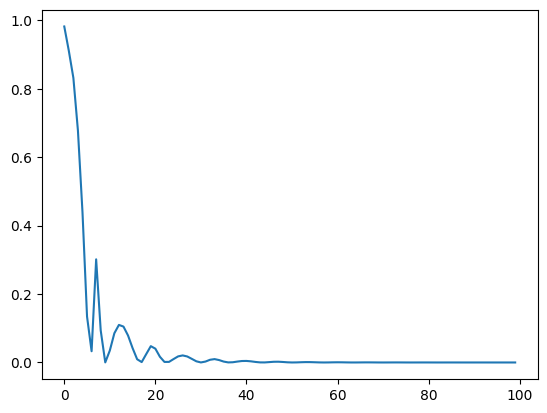

In [19]:
gcn = model([11] + [11*4]*5 + [11*2], device=device, dropout=dropout_p)
gcn.to(device)
optimizer = torch.optim.Adam(gcn.parameters(), lr=lr)

loss_values = []

for epoch in range(epochs):
  # prepare model for training
  gcn.train()
  optimizer.zero_grad()

  # prepare train data
  train_mask = torch.reshape(data.train_mask, (-1,))
  x = data.x
  edge_index = data.edge_index[:, train_mask]
  edge_weight = data.edge_weight[train_mask]

  # train
  pred = gcn(x, edge_index, edge_weight).to(device)

  # prepare validation data
  ground_truth = data.edge_attr[:, train_mask].to(device)
  ground_truth.requires_grad = True

  # calculate loss
  loss = crit(pred, ground_truth)
  loss_values.append(loss.item())
  loss.backward()
  optimizer.step()

# draw loss
plotLoss(loss_values)

# Evaluate

In [20]:
gcn.eval()

val_mask = torch.reshape(data.val_mask, (-1,))
x = data.x
edge_index = data.edge_index[:, val_mask]
edge_weight = data.edge_weight[val_mask]

pred = gcn(x, edge_index, edge_weight).to(device).T
class_pred = (torch.where(pred >= tie_value, win_value, loss_value) + 1)/2

ground_truth = data.edge_attr[:, val_mask].to(device).T
ground_truth.requires_grad = True
class_ground_truth = (ground_truth + 1)/2

R2 = M.R2Score()
R2.to(device)
R2.update(pred, ground_truth)
print(f"R2: {R2.compute()}")

MSE = M.MeanSquaredError()
MSE.to(device)
MSE.update(pred, ground_truth)
print(f"MSE: {MSE.compute()}")

BiAcc = M.BinaryAccuracy()
BiAcc.to(device)
BiAcc.update(torch.reshape(class_pred, (-1,)), torch.reshape(class_ground_truth, (-1,)))
print(f"BiAcc: {BiAcc.compute()}")

R2: -inf
MSE: 1.09948729232201e-07
BiAcc: 1.0
